Name : Amruta Rajopadhye <br /> 
Assignment 1

In [106]:
import numpy as np
import matplotlib.pylab as plt

In [107]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        self.x[0] = 1

def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)

    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [108]:
pos_fname = "autos_motorcycles/positive"
neg_fname = "autos_motorcycles/negative"
voc_fname = "autos_motorcycles/vocab"
train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)


In [109]:
# Length of the vocabulary
print('Number of examples in vocabulary')
print(len(vocab)-1)


Number of examples in vocabulary
5326


1. Number of terms in the vocabulary excluding bias constant = 5326
2. Features are created using bag of words model.
3. Positive label is showing motorcycles and Negative label is associated with automobiles.

In [114]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        self.last_update = dict()

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []

        
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights 
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration-1, train_nll, test_nll, train_acc, test_acc))
                iteration += 1
    
    def sgd_update(self, train_example, iteration):
        """
        Compute a stochastic gradient update to improve the NLL 

        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        """
        if iteration == 0:
            for k, _ in enumerate(self.w):
                self.last_update[k] = 1
            
        weight_sum = np.inner(self.w, train_example.x)
        muii = self.sigmoid(weight_sum) - train_example.y
        for k, weight in enumerate(self.w):
            if train_example.x[k] != 0:
                self.w[k] = self.w[k] - self.eta * muii * train_example.x[k]
                if k != 0:
                    shrinkage_factor = 1 - (2*self.eta*self.lam)
                    self.w[k] = self.w[k]*pow(shrinkage_factor, self.last_update[k])
            elif k != 0:
                self.last_update[k] += 1
                    


In [115]:
lr = LogReg(train_set, test_set, lam=0, eta=0.1)
lr.train(isVerbose=True)

Update     0  TrnNLL  817.381  TstNLL   86.169  TrnA 0.502  TstA 0.466
Update     5  TrnNLL  1049.003  TstNLL  107.930  TrnA 0.503  TstA 0.466
Update    10  TrnNLL  890.081  TstNLL   92.380  TrnA 0.534  TstA 0.500
Update    15  TrnNLL  556.595  TstNLL   64.324  TrnA 0.754  TstA 0.741
Update    20  TrnNLL  696.890  TstNLL   80.974  TrnA 0.622  TstA 0.647
Update    25  TrnNLL  488.492  TstNLL   57.228  TrnA 0.797  TstA 0.767
Update    30  TrnNLL  507.461  TstNLL   51.339  TrnA 0.779  TstA 0.784
Update    35  TrnNLL  495.434  TstNLL   51.101  TrnA 0.791  TstA 0.810
Update    40  TrnNLL  410.195  TstNLL   47.615  TrnA 0.829  TstA 0.828
Update    45  TrnNLL  391.587  TstNLL   45.013  TrnA 0.849  TstA 0.862
Update    50  TrnNLL  415.106  TstNLL   49.954  TrnA 0.815  TstA 0.784
Update    55  TrnNLL  396.954  TstNLL   43.742  TrnA 0.840  TstA 0.871
Update    60  TrnNLL  379.640  TstNLL   42.627  TrnA 0.854  TstA 0.862
Update    65  TrnNLL  366.340  TstNLL   42.640  TrnA 0.864  TstA 0.862
Updat

Update   605  TrnNLL  102.461  TstNLL   16.715  TrnA 0.967  TstA 0.940
Update   610  TrnNLL  103.237  TstNLL   16.854  TrnA 0.966  TstA 0.940
Update   615  TrnNLL  102.914  TstNLL   16.994  TrnA 0.965  TstA 0.940
Update   620  TrnNLL  101.213  TstNLL   14.997  TrnA 0.965  TstA 0.957
Update   625  TrnNLL  102.571  TstNLL   14.973  TrnA 0.965  TstA 0.948
Update   630  TrnNLL  102.983  TstNLL   14.954  TrnA 0.966  TstA 0.948
Update   635  TrnNLL  102.332  TstNLL   14.909  TrnA 0.966  TstA 0.957
Update   640  TrnNLL   99.177  TstNLL   15.063  TrnA 0.969  TstA 0.948
Update   645  TrnNLL   98.957  TstNLL   15.130  TrnA 0.969  TstA 0.948
Update   650  TrnNLL   94.392  TstNLL   15.183  TrnA 0.968  TstA 0.957
Update   655  TrnNLL   94.692  TstNLL   16.348  TrnA 0.967  TstA 0.966
Update   660  TrnNLL   93.940  TstNLL   16.103  TrnA 0.969  TstA 0.966
Update   665  TrnNLL   96.170  TstNLL   17.272  TrnA 0.970  TstA 0.957
Update   670  TrnNLL   96.310  TstNLL   17.246  TrnA 0.971  TstA 0.957
Update

In [116]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.006s

OK


In [117]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


In [162]:
acc = {}
lamda = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
for lam in lamda:
    lr = LogReg(train_set, test_set, lam, eta=0.1)
    lr.train()
    acc[lam] = lr.test_acc
    print(np.float64(lr.test_acc[-1]))


0.948275862069
0.474137931034
0.534482758621
0.465517241379
0.534482758621
0.465517241379


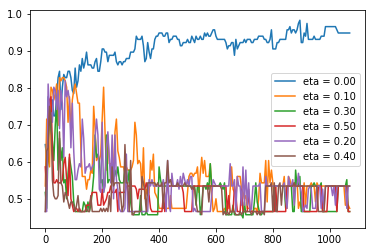

In [163]:
x = np.arange(len(acc[0]))
labels = []
plots = []
for i in acc:
    k,  = plt.plot(x*5, acc[i])
    plots.append(k)
    labels.append('eta = %.2f' % (i))

plt.legend(plots,labels)
plt.show()

In [164]:
acc_eta = {}
iter_acc = {}
eta_val = [0.1, 1, 10, 100]
for eta in eta_val:
    lr = LogReg(train_set, test_set, 0, eta)
    lr.train()
    acc_eta[eta] = lr.test_acc
    print(eta,np.float64(lr.test_acc[-1]))

0.1 0.948275862069
1 0.913793103448
10 0.879310344828
100 0.922413793103


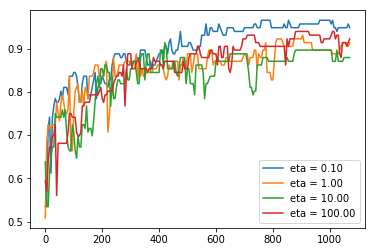

In [165]:
x = np.arange(len(acc_eta[0.1]))
labels = []
plots = []
for i in acc_eta:
    k,  = plt.plot(x*5, acc_eta[i])
    plots.append(k)
    labels.append('eta = %.2f' % (i))

plt.legend(plots,labels)
plt.show()

In [201]:
lr = LogReg(train_set, test_set, lam=0, eta=0.1)
lr.train()

weights = {}
for index,wt in enumerate(lr.w):
    weights[index] = wt
    
sorted_weights = sorted(weights.items(), key=lambda x: x[1])



In [202]:
print('most negative weights - key predictors for cars')
for i in range(0,11):
    print(vocab[sorted_weights[i][0]],sorted_weights[i][1])
    
print('most positive weights - key predictors for bikes')    
for i in range(0,11):
    print(vocab[sorted_weights[len(sorted_weights) - i-1][0]],sorted_weights[len(sorted_weights) - i-1][1])


most negative weights - key predictors for cars
cars -1.1201554885
car -1.10266918183
spring -0.771747079254
ford -0.752929223639
road -0.619276255366
acs -0.5861490991
please -0.584521230835
pack -0.558632935264
taurus -0.551596154622
warning -0.540582823355
truck -0.54051251283
most positive weights - key predictors for bikes
bike 2.25439539854
dod 2.09943499541
bikes 1.09098184899
riding 1.01936397081
ride 0.948036229455
piece 0.81876867091
helmet 0.731691180841
ge 0.72461507434
dog 0.631198449033
rider 0.626231796694
jonathan 0.620405347279


In [203]:
mid = int(len(vocab)/2)
print('most neutral weights - non predictors for classes')  
for i in range(-5,5):
    print(vocab[sorted_weights[mid+i][0]],sorted_weights[mid+i][1])
       

most neutral weights - non predictors for classes
driveways 1.52548420222e-07
rebel 1.6012352849e-07
watched 1.73751150367e-07
angles 1.74747979872e-07
concerns 1.75745408681e-07
exception 2.35622309323e-07
ignoring 2.49687305494e-07
lately 3.82070321899e-07
eagles 5.87150701103e-07
fold 6.32185943554e-07
